<a href="https://colab.research.google.com/github/BGR-EGHA/EGU23_GM3.3_ls_benchmark/blob/master/Exploration_of_SU_Benchmark_final_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SU Benchmark dataset

In [59]:
import ast
import geopandas as gpd
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import roc_curve, roc_auc_score

# New SU (Updated data July 9th 2023)

## Get the data

In [60]:
!wget --content-disposition https://dropcloud.irpi.cnr.it/index.php/s/NrC88BcJe3n0NOc/download

--2023-09-26 10:16:10--  https://dropcloud.irpi.cnr.it/index.php/s/NrC88BcJe3n0NOc/download
Resolving dropcloud.irpi.cnr.it (dropcloud.irpi.cnr.it)... 194.119.218.65
Connecting to dropcloud.irpi.cnr.it (dropcloud.irpi.cnr.it)|194.119.218.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10996372 (10M) [application/x-compressed]
Saving to: ‘data.tgz.1’

data.tgz.1          100%[===================>]  10.49M   651KB/s    in 24s     

2023-09-26 10:16:36 (442 KB/s) - ‘data.tgz.1’ saved [10996372/10996372]



In [61]:
!tar -xvzf data.tgz

data/
data/su_benchmark_final.csv
data/su_benchmark_final.gpkg


In [62]:
!wget https://idrogeo.isprambiente.it/opendata/frane/frane_piff_umbria_opendata.zip
!unzip frane_piff_umbria_opendata.zip

--2023-09-26 10:16:36--  https://idrogeo.isprambiente.it/opendata/frane/frane_piff_umbria_opendata.zip
Resolving idrogeo.isprambiente.it (idrogeo.isprambiente.it)... 193.206.192.71
Connecting to idrogeo.isprambiente.it (idrogeo.isprambiente.it)|193.206.192.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1615098 (1.5M) [application/zip]
Saving to: ‘frane_piff_umbria_opendata.zip.1’

frane_piff_umbria_o 100%[===================>]   1.54M  1.56MB/s    in 1.0s    

2023-09-26 10:16:38 (1.56 MB/s) - ‘frane_piff_umbria_opendata.zip.1’ saved [1615098/1615098]

Archive:  frane_piff_umbria_opendata.zip
replace frane_piff_opendataPoint.prj? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: frane_piff_opendataPoint.prj  
replace frane_piff_opendataPoint.shp? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: frane_piff_opendataPoint.shp  
replace frane_piff_opendataPoint.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: frane_piff_opendataPoint.shx  
repl

## Helper Functions

In [63]:
def get_roc_curve(df, model, label):
  fp, tp, thresh = roc_curve(df[label], df[model])
  return fp, tp, thresh

In [64]:
def calc_auc(x, y):
  """
  Calculates area under curve
  """
  auc = 0
  for i in range(1, len(x)):
      auc+=(x[i]-x[i-1])*y[i] - ((x[i]-x[i-1])*(y[i]-y[i-1])/2)
  return auc

In [65]:
def get_stats_sorted_combined_calc_df(df) -> tuple:
  max_avg = 0
  max_avg_col = ""
  max_single_fold = 0
  max_single_fold_col  = ""
  max_single_fold_fold  = 0
  for col in df:
    if df[col].median() > max_avg:
      max_avg = df[col].median()
      max_avg_col = df[col].name
    for i, r in df.iterrows():
      if r[col] > max_single_fold:
        max_single_fold = r[col]
        max_single_fold_col  = df[col].name
        max_single_fold_fold  = i
  print(f"{max_avg = } Column: {max_avg_col}")
  print(f"{max_single_fold = } Column: {max_single_fold_col} @ Fold {max_single_fold_fold+1}")
  return (max_avg, max_avg_col, max_single_fold, max_single_fold_col, max_single_fold_fold)

In [66]:
def get_success_rate(df, sort_col, event_col):
    sorted_df = df.sort_values(by=sort_col, ascending=False)
    count_norm = sorted_df[event_col]/sorted_df[event_col].sum()
    area_norm = sorted_df.area/sorted_df.area.sum()
    x=[0]
    for elem in area_norm.cumsum():
        x.append(elem)
    y=[0]
    for elem in count_norm.fillna(0).cumsum():
        y.append(elem)
    auc = calc_auc(x,y)
    return x, y, auc


# Explore the dataset - Data visualization

For simplicity reasons we do not perform again the pair plot analysis,  jennsen-shannon divergence and biserial correlation analyses for the data. Instead we just check again the multicollinearity of the datasets since new lithological informations were introduced.

In [67]:
gdf = gpd.read_file("data/su_benchmark_final.gpkg")

In [68]:
gdf.columns, len(gdf.columns)

(Index(['id', 'slope_aver', 'tcurv_aver', 'nthns_aver', 'nthns_stdd',
        'easns_aver', 'easns_stdd', 'twi_stddev', 'BLDFIE_ave', 'BLDFIE_std',
        'CLYPPT_ave', 'SLTPPT_ave', 'SLTPPT_std', 'SNDPPT_ave', 'D_sqrt_A',
        'lito2_perc', 'lito6_perc', 'lito8_perc', 'lito11_perc', 'lito12_perc',
        'presence1', 'presence2', 'geometry'],
       dtype='object'),
 23)

## Multicollinearity of the variables

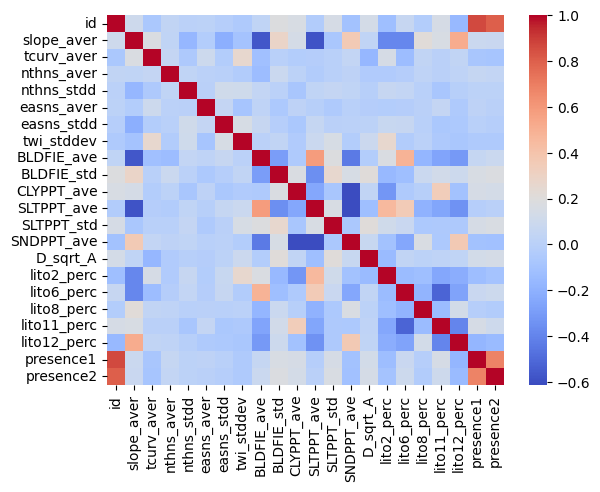

In [69]:
corr = gdf.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm",
        xticklabels=corr.columns,
        yticklabels=corr.columns);

The results show that some of the initially correlated variables were removed from the dataset. The new variables litho2_perc, litho6_perc, litho11_perc, litho12_perc show moderate to strong correlation with slope_aver, BLDFIE_ave, SNDPPT_ave and twi_stddev.

# Genarate 10-Fold Cross Validation dataset

As defined for the final experiment we generate a 10-fold cross-validation dataset. Notable is that since the folds are generated randomly differences to datasets of other groups may occur. To further harmonize the results a standard dataset (same dataset for all groups should be introduced) or a repeated 10-fold cross validation. With the repitition of the 10-fold cross validation the differences could be further diminished.

In [70]:
skip_list = ["id", "presence1", "presence2", "geometry"]
# I am only considering the current variables provided.
# set up normalized dataframe
gdf_norm = pd.DataFrame()
for col in gdf.columns:
  if col not in skip_list:
    if col in ['lito2_perc', 'lito6_perc', 'lito8_perc', 'lito11_perc', 'lito12_perc']:
      gdf_norm[col] = gdf[col]
    else:
      gdf_norm[col] = minmax_scale(gdf[col])

# set up 10 fold cross validation
kf_list = []
kf = KFold(n_splits=10, random_state=42, shuffle=True)
for i, (train_indices, test_indices) in enumerate(kf.split(gdf_norm)):
  kf_tmp = {}
  kf_tmp["X_train"] = gdf_norm.iloc[train_indices]
  kf_tmp["X_test"] = gdf_norm.iloc[test_indices]
  kf_tmp["y_train1"] = gdf["presence1"].iloc[train_indices]
  kf_tmp["y_test1"] = gdf["presence1"].iloc[test_indices]
  kf_tmp["y_train2"] = gdf["presence2"].iloc[train_indices]
  kf_tmp["y_test2"] = gdf["presence2"].iloc[test_indices]
  kf_list.append(kf_tmp)



# Classification with Logistic Regression (LR)
We start with the linear logistic regression model.

##SUs with label "presence1"

In [71]:
print("Total number SU:",gdf["presence1"].count())
print("Number of SU with landslides:", gdf["presence1"].value_counts()[1])
print("Number of SU without landslides", gdf["presence1"].value_counts()[0])

Total number SU: 7360
Number of SU with landslides: 3594
Number of SU without landslides 3766


In [72]:
selection_p1 = gdf[['presence1','slope_aver', 'BLDFIE_ave', 'CLYPPT_ave',
                    'SLTPPT_ave', 'SNDPPT_ave', 'D_sqrt_A', 'lito2_perc',
                    'lito6_perc', 'lito8_perc', 'lito11_perc', 'lito12_perc']]

### Single Variable Performance

In the single variable performance we check how a model with a single variable is able to explain the labeled dataset. This provide us some intuition for the variable importance and allow to better design the next analysis step of stepwise data integration.



In [73]:
performance_df_lr1 = pd.DataFrame()
for col in gdf.columns:
  if col not in skip_list:
    auc_test_list = []
    for i, kf in enumerate(kf_list):
      lr_tmp = LogisticRegression(random_state=42).fit(kf["X_train"][col].values.reshape(-1, 1), kf["y_train1"])
      auc_train = roc_auc_score(kf["y_train1"], lr_tmp.predict_proba(kf["X_train"][col].values.reshape(-1, 1))[:, 1])
      auc_test = roc_auc_score(kf["y_test1"], lr_tmp.predict_proba(kf["X_test"][col].values.reshape(-1, 1))[:, 1])
      print(f"{i+1: <{2}}. Fold: X: {col: <{11}} -> {auc_train = : <{19}} - {auc_test = : <{19}}")
      auc_test_list.append(auc_test)
    performance_df_lr1[col] = auc_test_list

1 . Fold: X: slope_aver  -> auc_train = 0.5782781529451206  - auc_test = 0.557468081492804  
2 . Fold: X: slope_aver  -> auc_train = 0.5774572446902428  - auc_test = 0.5653293856402665 
3 . Fold: X: slope_aver  -> auc_train = 0.5734496288069724  - auc_test = 0.6008542461056428 
4 . Fold: X: slope_aver  -> auc_train = 0.5748819668387105  - auc_test = 0.588978415138971  
5 . Fold: X: slope_aver  -> auc_train = 0.5785560255275463  - auc_test = 0.5553192589146599 
6 . Fold: X: slope_aver  -> auc_train = 0.5739352163498813  - auc_test = 0.5979536052009456 
7 . Fold: X: slope_aver  -> auc_train = 0.5738759057229992  - auc_test = 0.5957523957523958 
8 . Fold: X: slope_aver  -> auc_train = 0.5775450173305641  - auc_test = 0.564453125        
9 . Fold: X: slope_aver  -> auc_train = 0.5793552323232398  - auc_test = 0.5485404990289684 
10. Fold: X: slope_aver  -> auc_train = 0.5750418239435463  - auc_test = 0.5874246721020915 
1 . Fold: X: tcurv_aver  -> auc_train = 0.5457977836618614  - auc_test

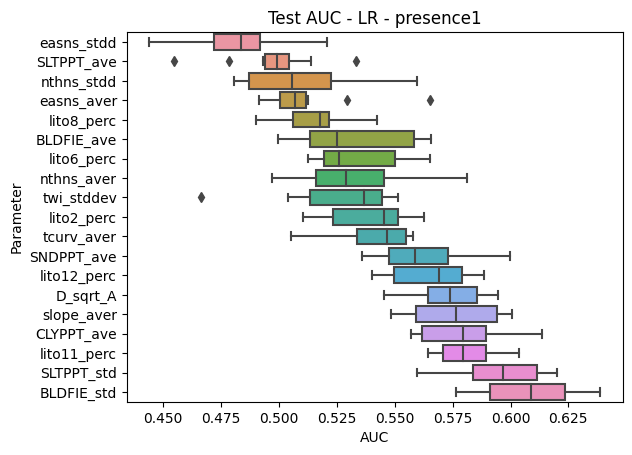

In [74]:
plt.title("Test AUC - LR - presence1")
plt.xlabel("AUC")
plt.ylabel("Parameter")
sorted_performance_df_lr1 = performance_df_lr1.reindex(performance_df_lr1.median().sort_values().index, axis=1)
sns.boxplot(sorted_performance_df_lr1, orient="h");

- The single varible performance indicate still a possible confound with the SU
area even if this variable is not explicitely present in the data anymore. We see that in the LR model variables characterising the variance of values such as BLDFIE_std and SLTPPT_std has the strongest performance. The higher variety of values can indirectly point to a possibly larger extent of the SU.
- Boxplots of the 10-folds suggest that the distribution of the variance is mostly skewed. Therefore we use median as the measure of central tendency. Median is more robust for possible outliers. For well defined normal distribution mean and median provide identical values.

### Stepwise data integration

In the stepwise combination we start with the variable with the best performance. After, we integrate stepwise additional variables according to their performance. If the combined model performance measured by AUROC (median) does not improve after an additional variable was integrated, the last added variable is dropped from the model.

In [75]:
lr1_max_to_min = list(reversed(sorted_performance_df_lr1.columns.to_list()))
performance_df_lr1_combined = pd.DataFrame()
columns_for_calc = []
old_test_auc = 0
for col in lr1_max_to_min:
  if col not in skip_list:
    columns_for_calc.append(col)
    auc_test_list = []
    for i, kf in enumerate(kf_list):
      tmp_train_df = pd.DataFrame()
      tmp_test_df = pd.DataFrame()
      for c in columns_for_calc:
        tmp_train_df[c] = kf["X_train"][c]
        tmp_test_df[c] = kf["X_test"][c]
      lr_tmp_comb1 = LogisticRegression(random_state=42, solver="lbfgs", max_iter=200).fit(tmp_train_df, kf["y_train1"])
      auc_train = roc_auc_score(kf["y_train1"], lr_tmp_comb1.predict_proba(tmp_train_df)[:, 1])
      auc_test = roc_auc_score(kf["y_test1"], lr_tmp_comb1.predict_proba(tmp_test_df)[:, 1])
      #print(f"{i+1: <{2}}. Fold: X: {tmp_train_df.columns} -> {lr_tmp_comb1.coef_}\n{auc_train = : <{19}} - {auc_test = : <{19}}")
      auc_test_list.append(auc_test)
    mean_test_auc = np.median(auc_test_list)
    performance_df_lr1_combined[str(columns_for_calc)] = auc_test_list
    print(columns_for_calc)
    if mean_test_auc <= old_test_auc:
      print(f"Average Test AUC did not improve with {col}. Best: {old_test_auc}. New: {mean_test_auc}.")
      print(f"Removing {columns_for_calc.pop()} from list of columns.")
    else:
      print(f"Average Test AUC improved to {mean_test_auc}.")
      old_test_auc = mean_test_auc

['BLDFIE_std']
Average Test AUC improved to 0.6089992004207281.
['BLDFIE_std', 'SLTPPT_std']
Average Test AUC improved to 0.6219983113289136.
['BLDFIE_std', 'SLTPPT_std', 'lito11_perc']
Average Test AUC improved to 0.6394393392444843.
['BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave']
Average Test AUC improved to 0.6494154231444057.
['BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave', 'slope_aver']
Average Test AUC improved to 0.6506453351605208.
['BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave', 'slope_aver', 'D_sqrt_A']
Average Test AUC improved to 0.6557711762403727.
['BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave', 'slope_aver', 'D_sqrt_A', 'lito12_perc']
Average Test AUC improved to 0.6999183415384533.
['BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave', 'slope_aver', 'D_sqrt_A', 'lito12_perc', 'SNDPPT_ave']
Average Test AUC improved to 0.7005681831100826.
['BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave', 'slope_aver', 'D_sqrt_A', 'lito12_pe

Following plot visualize the stepwise performance of the model beginning with the single variable BLDFIE_std. Through the stepwise integration only one variable (nthns_aver) was dropped.

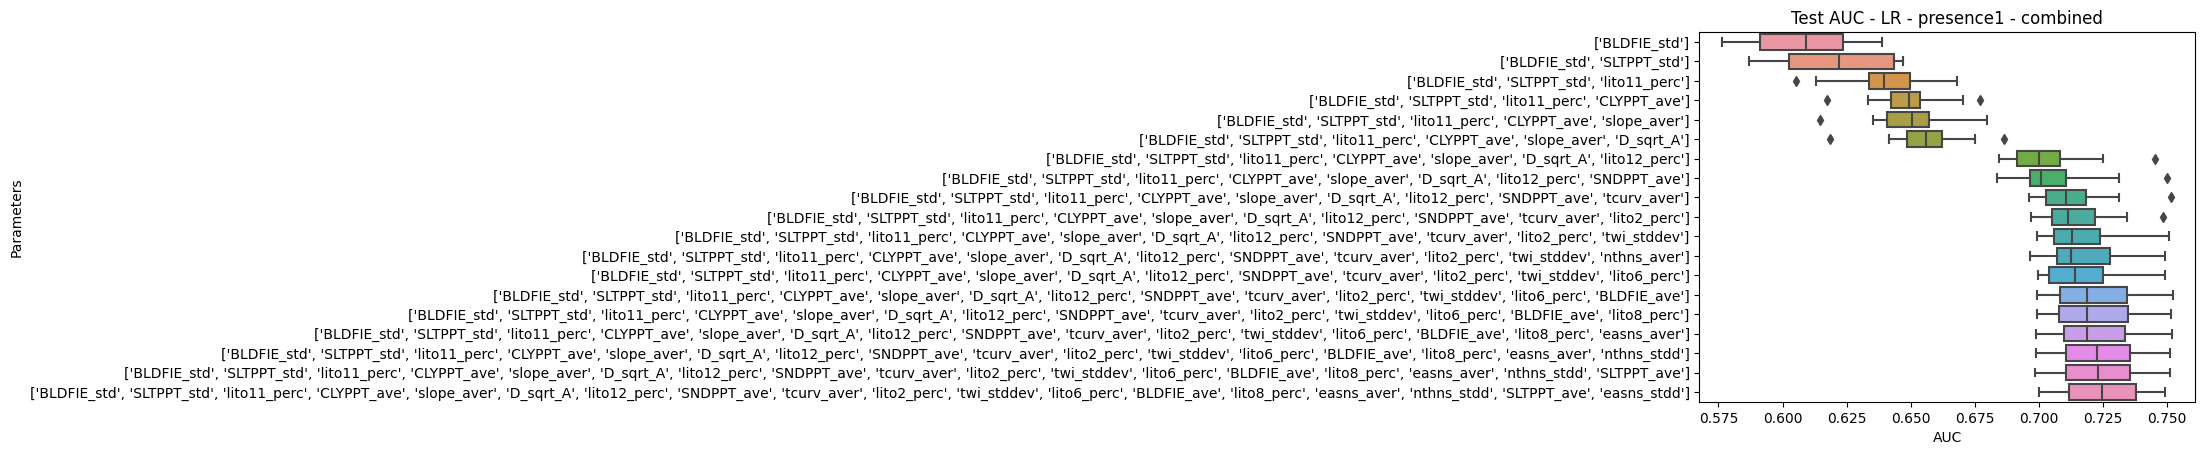

In [76]:
plt.title("Test AUC - LR - presence1 - combined")
plt.xlabel("AUC")
plt.ylabel("Parameters")
sorted_performance_df_lr1_combined = performance_df_lr1_combined.reindex(performance_df_lr1_combined.median().index, axis=1)
sns.boxplot(sorted_performance_df_lr1_combined, orient="h");

## SUs with label "presence2"

In the following lines of code we repeat the upper steps for the label presence2.

In [77]:
print("Total number SU:",gdf["presence1"].count())
print("Number of SU with landslides:", gdf["presence2"].value_counts()[1])
print("Number of SU without landslides", gdf["presence2"].value_counts()[0])

Total number SU: 7360
Number of SU with landslides: 2271
Number of SU without landslides 5089


### Single Variable Performance

In [78]:
performance_df_lr2 = pd.DataFrame()
for col in gdf.columns:
  if col not in skip_list:
    auc_test_list = []
    for i, kf in enumerate(kf_list):
      lr_tmp = LogisticRegression(random_state=42).fit(kf["X_train"][col].values.reshape(-1, 1), kf["y_train2"])
      auc_train = roc_auc_score(kf["y_train2"], lr_tmp.predict_proba(kf["X_train"][col].values.reshape(-1, 1))[:, 1])
      auc_test = roc_auc_score(kf["y_test2"], lr_tmp.predict_proba(kf["X_test"][col].values.reshape(-1, 1))[:, 1])
      print(f"{i+1: <{2}}. Fold: X: {col: <{11}} -> {auc_train = : <{19}} - {auc_test = : <{19}}")
      auc_test_list.append(auc_test)
    performance_df_lr2[col] = auc_test_list

1 . Fold: X: slope_aver  -> auc_train = 0.5748334255343082  - auc_test = 0.5385892328123403 
2 . Fold: X: slope_aver  -> auc_train = 0.5725902934145517  - auc_test = 0.5586847128231824 
3 . Fold: X: slope_aver  -> auc_train = 0.568481854558376   - auc_test = 0.5926927603736258 
4 . Fold: X: slope_aver  -> auc_train = 0.5692764908323906  - auc_test = 0.5888503246304738 
5 . Fold: X: slope_aver  -> auc_train = 0.57272910036615    - auc_test = 0.5561184689897561 
6 . Fold: X: slope_aver  -> auc_train = 0.5698380177578     - auc_test = 0.5841461620349134 
7 . Fold: X: slope_aver  -> auc_train = 0.5680679636680522  - auc_test = 0.5983680065350772 
8 . Fold: X: slope_aver  -> auc_train = 0.5724637125037733  - auc_test = 0.5597537602783886 
9 . Fold: X: slope_aver  -> auc_train = 0.570097777333646   - auc_test = 0.5817873450750163 
10. Fold: X: slope_aver  -> auc_train = 0.5734736101186986  - auc_test = 0.5507709880068532 
1 . Fold: X: tcurv_aver  -> auc_train = 0.5529048979319691  - auc_test

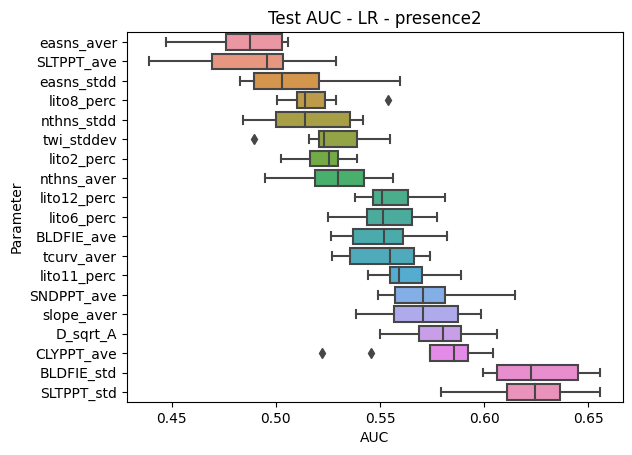

In [79]:
plt.title("Test AUC - LR - presence2")
plt.xlabel("AUC")
plt.ylabel("Parameter")
sorted_performance_df_lr2 = performance_df_lr2.reindex(performance_df_lr2.median().sort_values().index, axis=1)
sns.boxplot(sorted_performance_df_lr2, orient="h");


### Stepwise combination

In [80]:
lr2_max_to_min = list(reversed(sorted_performance_df_lr2.columns.to_list()))
performance_df_lr2_combined = pd.DataFrame()
columns_for_calc = []
old_test_auc = 0
for col in lr2_max_to_min:
  if col not in skip_list:
    columns_for_calc.append(col)
    auc_test_list = []
    for i, kf in enumerate(kf_list):
      tmp_train_df = pd.DataFrame()
      tmp_test_df = pd.DataFrame()
      for c in columns_for_calc:
        tmp_train_df[c] = kf["X_train"][c]
        tmp_test_df[c] = kf["X_test"][c]
      lr_tmp_comb2 = LogisticRegression(random_state=42, solver="lbfgs", max_iter=200).fit(tmp_train_df, kf["y_train2"])
      auc_train = roc_auc_score(kf["y_train2"], lr_tmp_comb2.predict_proba(tmp_train_df)[:, 1])
      auc_test = roc_auc_score(kf["y_test2"], lr_tmp_comb2.predict_proba(tmp_test_df)[:, 1])
      #print(f"{i+1: <{2}}. Fold: X: {tmp_train_df.columns} -> {lr_tmp_comb2.coef_}\n{auc_train = : <{19}} - {auc_test = : <{19}}")
      auc_test_list.append(auc_test)
    mean_test_auc = np.median(auc_test_list)
    performance_df_lr2_combined[str(columns_for_calc)] = auc_test_list
    print(columns_for_calc)
    if mean_test_auc <= old_test_auc:
      print(f"Average Test AUC did not improve with {col}. Best: {old_test_auc}. New: {mean_test_auc}.")
      print(f"Removing {columns_for_calc.pop()} from list of columns.")
    else:
      print(f"Average Test AUC improved to {mean_test_auc}.")
      old_test_auc = mean_test_auc

['SLTPPT_std']
Average Test AUC improved to 0.6243101466481564.
['SLTPPT_std', 'BLDFIE_std']
Average Test AUC improved to 0.6517648714015787.
['SLTPPT_std', 'BLDFIE_std', 'CLYPPT_ave']
Average Test AUC improved to 0.6560034436992359.
['SLTPPT_std', 'BLDFIE_std', 'CLYPPT_ave', 'D_sqrt_A']
Average Test AUC improved to 0.6598201320817363.
['SLTPPT_std', 'BLDFIE_std', 'CLYPPT_ave', 'D_sqrt_A', 'slope_aver']
Average Test AUC did not improve with slope_aver. Best: 0.6598201320817363. New: 0.6584526769211767.
Removing slope_aver from list of columns.
['SLTPPT_std', 'BLDFIE_std', 'CLYPPT_ave', 'D_sqrt_A', 'SNDPPT_ave']
Average Test AUC improved to 0.6705068341201879.
['SLTPPT_std', 'BLDFIE_std', 'CLYPPT_ave', 'D_sqrt_A', 'SNDPPT_ave', 'lito11_perc']
Average Test AUC improved to 0.6755872913751133.
['SLTPPT_std', 'BLDFIE_std', 'CLYPPT_ave', 'D_sqrt_A', 'SNDPPT_ave', 'lito11_perc', 'tcurv_aver']
Average Test AUC improved to 0.6784919290050513.
['SLTPPT_std', 'BLDFIE_std', 'CLYPPT_ave', 'D_sqrt_A

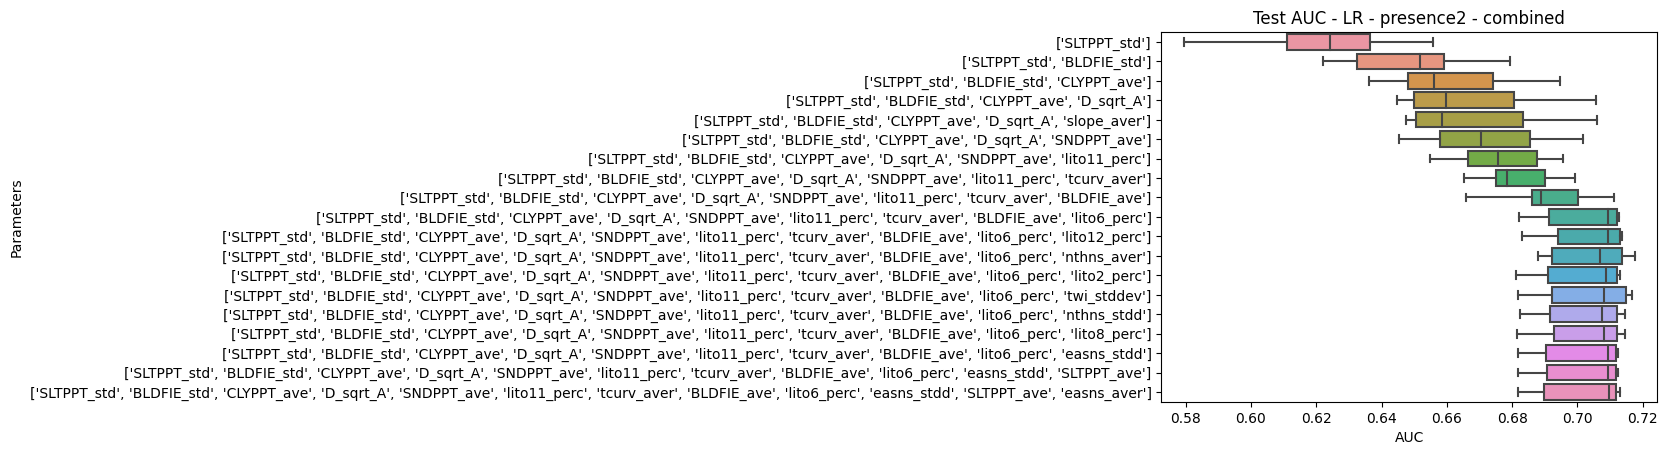

In [81]:
plt.title("Test AUC - LR - presence2 - combined")
plt.xlabel("AUC")
plt.ylabel("Parameters")
sorted_performance_df_lr2_combined = performance_df_lr2_combined.reindex(performance_df_lr2_combined.median().index, axis=1)
sns.boxplot(sorted_performance_df_lr2_combined, orient="h");

The presence2 label allow to generate a model with less variables but lower performance.

## Vizualize Results

Before we can visualize the results we need to recreate the strongest model, as its lost in the for loop, so we look at the results and recreate the model, but this time for the whole training dataset.

In [82]:
# Create Copy of regular dataframe to extent with LR results.
gdf_lr_results = gdf.copy()

### LR with Presence 1 label

max_avg = 0.7244147094339609 Column: ['BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave', 'slope_aver', 'D_sqrt_A', 'lito12_perc', 'SNDPPT_ave', 'tcurv_aver', 'lito2_perc', 'twi_stddev', 'lito6_perc', 'BLDFIE_ave', 'lito8_perc', 'easns_aver', 'nthns_stdd', 'SLTPPT_ave', 'easns_stdd']
max_single_fold = 0.752164598108747 Column: ['BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave', 'slope_aver', 'D_sqrt_A', 'lito12_perc', 'SNDPPT_ave', 'tcurv_aver', 'lito2_perc', 'twi_stddev', 'lito6_perc', 'BLDFIE_ave'] @ Fold 6


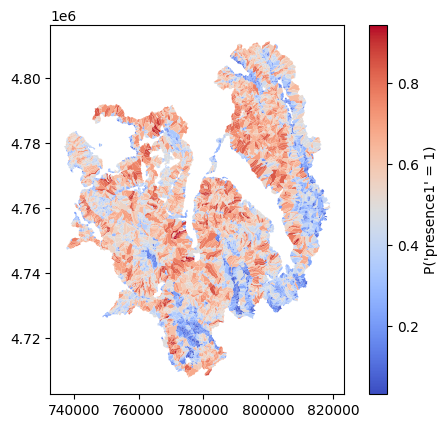

In [83]:
max_avg, max_avg_column, max_singlef, max_singlef_col, max_singlef_fold = get_stats_sorted_combined_calc_df(sorted_performance_df_lr1_combined)
columns = ast.literal_eval(max_avg_column) #list of columns for the model with the max median value
for i, kf in enumerate(kf_list):
  tmp_train_df = kf["X_train"].filter(columns)
  tmp_lr_presence1 = LogisticRegression(random_state=42, solver="lbfgs", max_iter=200).fit(tmp_train_df, kf["y_train1"])
  tmp_lr_presence1_preds = tmp_lr_presence1.predict_proba(gdf_norm[columns])[:, 1]
  gdf_lr_results[f"presence1_preds_{i}_fold"] = tmp_lr_presence1_preds
presence1_pred_cols = [col for col in gdf_lr_results.columns if "presence1_preds_" in col]
gdf_lr_results["presence1_median_pred"] = gdf_lr_results[presence1_pred_cols].median(axis=1)
gdf_lr_results["presence1_mean_pred"] = gdf_lr_results[presence1_pred_cols].mean(axis=1)
gdf_lr_results["presence1_std_pred"] = gdf_lr_results[presence1_pred_cols].std(axis=1)
gdf_lr_results.plot(column="presence1_median_pred", legend=True,
                    cmap="coolwarm",
                    legend_kwds={'label': "P('presence1' = 1)"});

Text(0, 0.5, 'Total landslides (labels)')

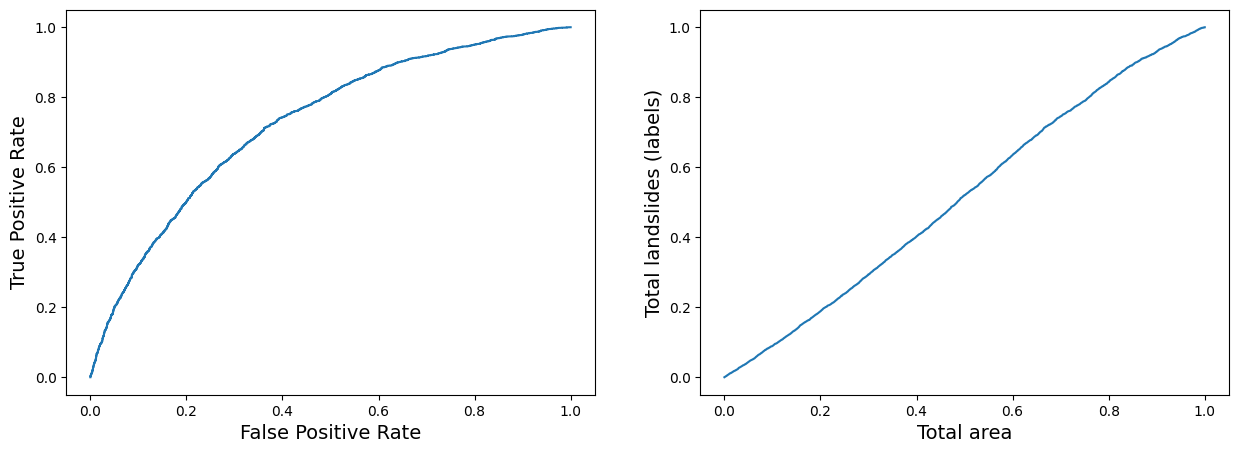

In [84]:
x, y, auc = get_success_rate(gdf_lr_results, "presence1_median_pred", "presence1")
fp, tp, thresh= get_roc_curve(gdf_lr_results,"presence1_median_pred", "presence1" )
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.set_xlabel("False Positive Rate", fontsize=14)
ax.set_ylabel("True Positive Rate", fontsize=14)
ax.plot(fp, tp, label=f"{col} AUC: {round(roc_auc_score(gdf['presence1'], gdf[col]), 2)}")


ax2 = fig.add_subplot(122)
ax2.plot(x, y, label=f"{col} AUC: {round(auc, 2)}")
ax2.set_xlabel("Total area", fontsize=14)
ax2.set_ylabel("Total landslides (labels)", fontsize=14)

### LR with Presence 2 label

max_avg = 0.7095297547310795 Column: ['SLTPPT_std', 'BLDFIE_std', 'CLYPPT_ave', 'D_sqrt_A', 'SNDPPT_ave', 'lito11_perc', 'tcurv_aver', 'BLDFIE_ave', 'lito6_perc', 'easns_stdd', 'SLTPPT_ave', 'easns_aver']
max_single_fold = 0.7175342703453063 Column: ['SLTPPT_std', 'BLDFIE_std', 'CLYPPT_ave', 'D_sqrt_A', 'SNDPPT_ave', 'lito11_perc', 'tcurv_aver', 'BLDFIE_ave', 'lito6_perc', 'nthns_aver'] @ Fold 2


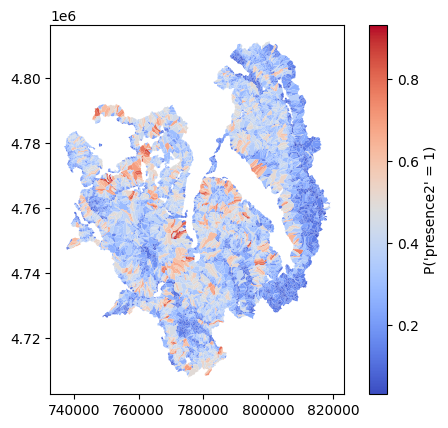

In [86]:
max_avg, max_avg_column, max_singlef, max_singlef_col, max_singlef_fold = get_stats_sorted_combined_calc_df(sorted_performance_df_lr2_combined)
columns = ast.literal_eval(max_avg_column) #list of columns for the model with the max median value
for i, kf in enumerate(kf_list):
  tmp_train_df = kf["X_train"].filter(columns)
  tmp_lr_presence2 = LogisticRegression(random_state=42, solver="lbfgs", max_iter=200).fit(tmp_train_df, kf["y_train2"])
  tmp_lr_presence2_preds = tmp_lr_presence2.predict_proba(gdf_norm[columns])[:, 1]
  gdf_lr_results[f"presence2_preds_{i}_fold"] = tmp_lr_presence2_preds
presence2_pred_cols = [col for col in gdf_lr_results.columns if "presence2_preds_" in col]
gdf_lr_results["presence2_median_pred"] = gdf_lr_results[presence2_pred_cols].median(axis=1)
gdf_lr_results["presence2_mean_pred"] = gdf_lr_results[presence2_pred_cols].mean(axis=1)
gdf_lr_results["presence2_std_pred"] = gdf_lr_results[presence2_pred_cols].std(axis=1)
gdf_lr_results.plot(column="presence2_median_pred", legend=True,
                    cmap="coolwarm",
                    legend_kwds={'label': "P('presence2' = 1)"});

Text(0, 0.5, 'Total landslides (labels)')

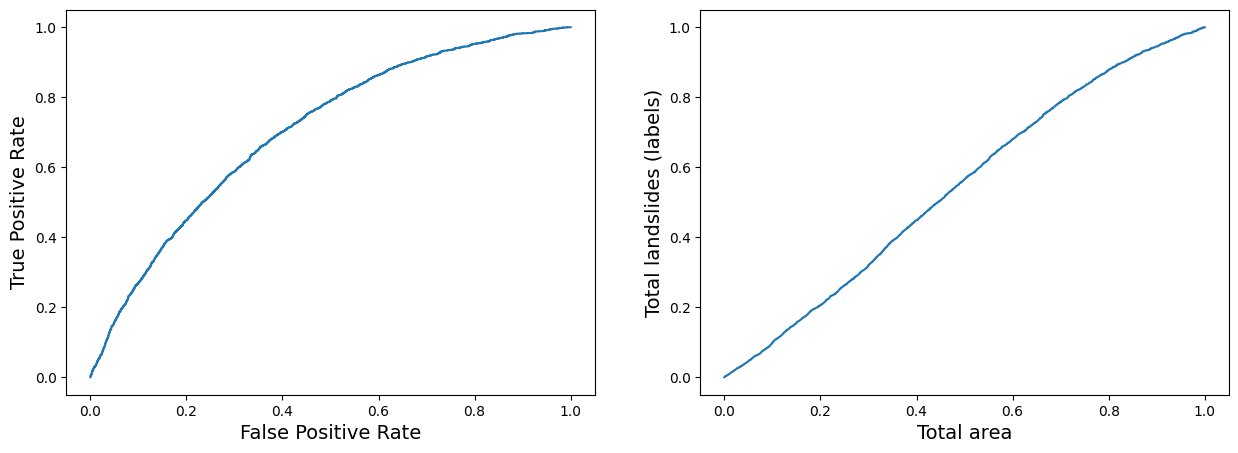

In [88]:
x, y, auc = get_success_rate(gdf_lr_results, "presence2_median_pred", "presence2")
fp, tp, thresh= get_roc_curve(gdf_lr_results,"presence2_median_pred", "presence2" )
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.set_xlabel("False Positive Rate", fontsize=14)
ax.set_ylabel("True Positive Rate", fontsize=14)
ax.plot(fp, tp, label=f"{col} AUC: {round(roc_auc_score(gdf['presence2'], gdf[col]), 2)}")


ax2 = fig.add_subplot(122)
ax2.plot(x, y, label=f"{col} AUC: {round(auc, 2)}")
ax2.set_xlabel("Total area", fontsize=14)
ax2.set_ylabel("Total landslides (labels)", fontsize=14)

Although AUROC for both presence1 and presence2 suggest a moderate model performance of 0.70-0.72, the success rate considering the areal extent of SUs indicate non-informative models.

In [89]:
gdf_lr_results.to_file("lr_output.gpkg")

# Classification with ANN

## SUs with label "presence1"

### Single Variable Performance

In [90]:
performance_df_ann1 = pd.DataFrame()
for col in gdf.columns:
  if col not in skip_list:
    auc_test_list = []
    for i, kf in enumerate(kf_list):
      ann_tmp1 = MLPClassifier(random_state=42, max_iter=300).fit(kf["X_train"][col].values.reshape(-1, 1), kf["y_train1"])
      auc_train = roc_auc_score(kf["y_train1"], ann_tmp1.predict_proba(kf["X_train"][col].values.reshape(-1, 1))[:, 1])
      auc_test = roc_auc_score(kf["y_test1"], ann_tmp1.predict_proba(kf["X_test"][col].values.reshape(-1, 1))[:, 1])
      print(f"{i+1: <{2}}. Fold: X: {col: <{11}} -> {auc_train = : <{19}} - {auc_test = : <{19}}")
      auc_test_list.append(auc_test)
    performance_df_ann1[col] = auc_test_list

1 . Fold: X: slope_aver  -> auc_train = 0.6451294612414503  - auc_test = 0.648036153386057  
2 . Fold: X: slope_aver  -> auc_train = 0.6466900203561969  - auc_test = 0.6312361213915618 
3 . Fold: X: slope_aver  -> auc_train = 0.6418675015286994  - auc_test = 0.6742706393544382 
4 . Fold: X: slope_aver  -> auc_train = 0.6450728885097851  - auc_test = 0.6502439384979303 
5 . Fold: X: slope_aver  -> auc_train = 0.6509754181650464  - auc_test = 0.5935845461996855 
6 . Fold: X: slope_aver  -> auc_train = 0.642441390608268   - auc_test = 0.6541371158392435 
7 . Fold: X: slope_aver  -> auc_train = 0.6475681747313144  - auc_test = 0.6242054242054242 
8 . Fold: X: slope_aver  -> auc_train = 0.645654718105177   - auc_test = 0.6418531013257576 
9 . Fold: X: slope_aver  -> auc_train = 0.6438612826589459  - auc_test = 0.656727439208997  
10. Fold: X: slope_aver  -> auc_train = 0.6445269470254373  - auc_test = 0.6428497577691126 
1 . Fold: X: tcurv_aver  -> auc_train = 0.5622866278499604  - auc_test

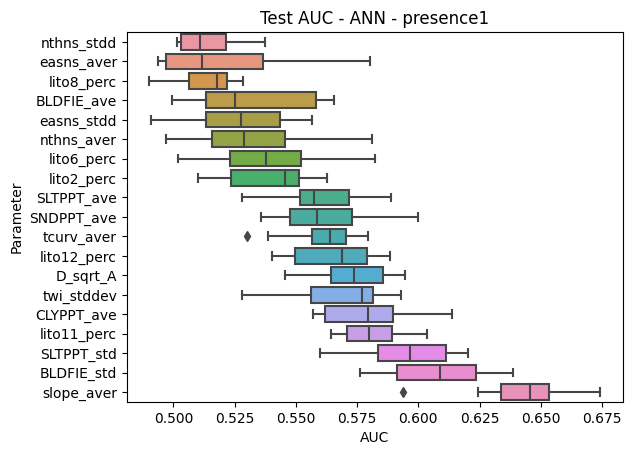

In [91]:
plt.title("Test AUC - ANN - presence1")
plt.xlabel("AUC")
plt.ylabel("Parameter")
sorted_performance_df_ann1 = performance_df_ann1.reindex(performance_df_ann1.median().sort_values().index, axis=1)
sns.boxplot(sorted_performance_df_ann1, orient="h");

### Stepwise integration

In [92]:
ann1_max_to_min = list(reversed(sorted_performance_df_ann1.columns.to_list()))
performance_df_ann1_combined = pd.DataFrame()
columns_for_calc = []
old_test_auc = 0
for col in ann1_max_to_min:
  if col not in skip_list:
    columns_for_calc.append(col)
    auc_test_list = []
    for i, kf in enumerate(kf_list):
      tmp_train_df = pd.DataFrame()
      tmp_test_df = pd.DataFrame()
      for c in columns_for_calc:
        tmp_train_df[c] = kf["X_train"][c]
        tmp_test_df[c] = kf["X_test"][c]
      ann_tmp_comb1 = MLPClassifier(random_state=42, max_iter=500).fit(tmp_train_df, kf["y_train1"])
      auc_train = roc_auc_score(kf["y_train1"], ann_tmp_comb1.predict_proba(tmp_train_df)[:, 1])
      auc_test = roc_auc_score(kf["y_test1"], ann_tmp_comb1.predict_proba(tmp_test_df)[:, 1])
      #print(f"{i+1: <{2}}. Fold: X: {tmp_train_df.columns} -> {auc_train = : <{19}} - {auc_test = : <{19}}")
      auc_test_list.append(auc_test)
    mean_test_auc = np.median(auc_test_list)
    performance_df_ann1_combined[str(columns_for_calc)] = auc_test_list
    print(columns_for_calc)
    if mean_test_auc <= old_test_auc:
      print(f"Average Test AUC did not improve with {col}. Best: {old_test_auc}. New: {mean_test_auc}.")
      print(f"Removing {columns_for_calc.pop()} from list of columns.")
    else:
      print(f"Average Test AUC improved to {mean_test_auc}.")
      old_test_auc = mean_test_auc

['slope_aver']
Average Test AUC improved to 0.6454429555775848.
['slope_aver', 'BLDFIE_std']
Average Test AUC improved to 0.6704995944915301.
['slope_aver', 'BLDFIE_std', 'SLTPPT_std']
Average Test AUC improved to 0.6993970112921725.
['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'lito11_perc']
Average Test AUC improved to 0.7170835065912786.
['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave']
Average Test AUC improved to 0.7218202522865735.
['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave', 'twi_stddev']
Average Test AUC improved to 0.7274848066163042.
['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave', 'twi_stddev', 'D_sqrt_A']
Average Test AUC did not improve with D_sqrt_A. Best: 0.7274848066163042. New: 0.726667407471352.
Removing D_sqrt_A from list of columns.
['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave', 'twi_stddev', 'lito12_perc']
Average Test AUC improved to 0.744551052353272.
['slope_aver', 'BL

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave', 'twi_stddev', 'lito12_perc', 'tcurv_aver', 'SNDPPT_ave', 'SLTPPT_ave', 'lito2_perc', 'easns_stdd', 'BLDFIE_ave']
Average Test AUC improved to 0.7691586019627243.
['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave', 'twi_stddev', 'lito12_perc', 'tcurv_aver', 'SNDPPT_ave', 'SLTPPT_ave', 'lito2_perc', 'easns_stdd', 'BLDFIE_ave', 'lito8_perc']
Average Test AUC improved to 0.7741962384190364.
['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave', 'twi_stddev', 'lito12_perc', 'tcurv_aver', 'SNDPPT_ave', 'SLTPPT_ave', 'lito2_perc', 'easns_stdd', 'BLDFIE_ave', 'lito8_perc', 'easns_aver']
Average Test AUC did not improve with easns_aver. Best: 0.7741962384190364. New: 0.7694040155660412.
Removing easns_aver from list of columns.
['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave', 'twi_stddev', 'lito12_perc', 'tcurv_aver', 'SNDPPT_ave', 'SLTPPT_ave', 'lito2_perc', 'easn

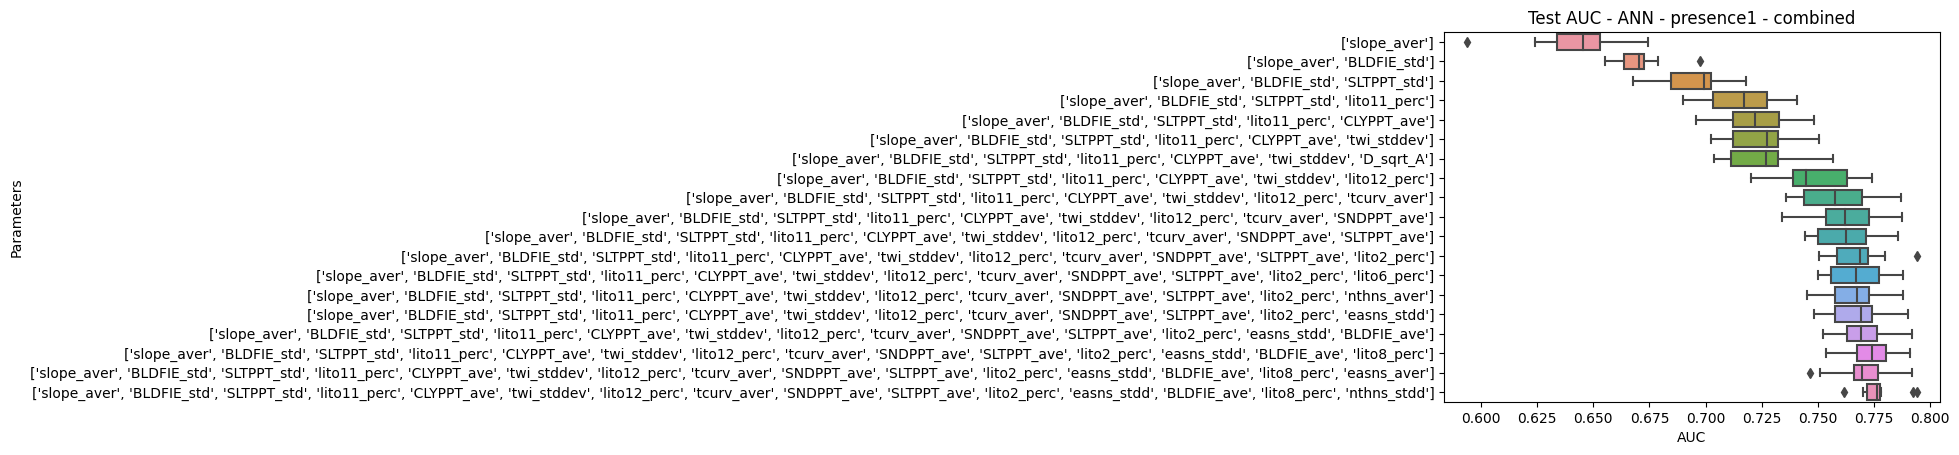

In [93]:
plt.title("Test AUC - ANN - presence1 - combined")
plt.xlabel("AUC")
plt.ylabel("Parameters")
sorted_performance_df_ann1_combined = performance_df_ann1_combined.reindex(performance_df_ann1_combined.median().index, axis=1)
sns.boxplot(sorted_performance_df_ann1_combined, orient="h");

## SUs with label presence2

### Single Variable Performance

In [94]:
performance_df_ann2 = pd.DataFrame()
for col in gdf.columns:
  if col not in skip_list:
    auc_test_list = []
    for i, kf in enumerate(kf_list):
      ann_tmp1 = MLPClassifier(random_state=42, max_iter=300).fit(kf["X_train"][col].values.reshape(-1, 1), kf["y_train2"])
      auc_train = roc_auc_score(kf["y_train2"], ann_tmp1.predict_proba(kf["X_train"][col].values.reshape(-1, 1))[:, 1])
      auc_test = roc_auc_score(kf["y_test2"], ann_tmp1.predict_proba(kf["X_test"][col].values.reshape(-1, 1))[:, 1])
      print(f"{i+1: <{2}}. Fold: X: {col: <{11}} -> {auc_train = : <{19}} - {auc_test = : <{19}}")
      auc_test_list.append(auc_test)
    performance_df_ann2[col] = auc_test_list

1 . Fold: X: slope_aver  -> auc_train = 0.6336601089994252  - auc_test = 0.6485851465931147 
2 . Fold: X: slope_aver  -> auc_train = 0.6384370873515801  - auc_test = 0.6024813465209092 
3 . Fold: X: slope_aver  -> auc_train = 0.6306400342978974  - auc_test = 0.6775599128540305 
4 . Fold: X: slope_aver  -> auc_train = 0.6355981200094071  - auc_test = 0.633141663213151  
5 . Fold: X: slope_aver  -> auc_train = 0.6418855653081477  - auc_test = 0.5724401011529724 
6 . Fold: X: slope_aver  -> auc_train = 0.6359784522171613  - auc_test = 0.6277922505041413 
7 . Fold: X: slope_aver  -> auc_train = 0.634658956532485   - auc_test = 0.63811122062101   
8 . Fold: X: slope_aver  -> auc_train = 0.6368471576286883  - auc_test = 0.6224883636716921 
9 . Fold: X: slope_aver  -> auc_train = 0.6325734621828141  - auc_test = 0.6603957382039574 
10. Fold: X: slope_aver  -> auc_train = 0.6345118218563034  - auc_test = 0.6415410973948952 
1 . Fold: X: tcurv_aver  -> auc_train = 0.585338985472487   - auc_test

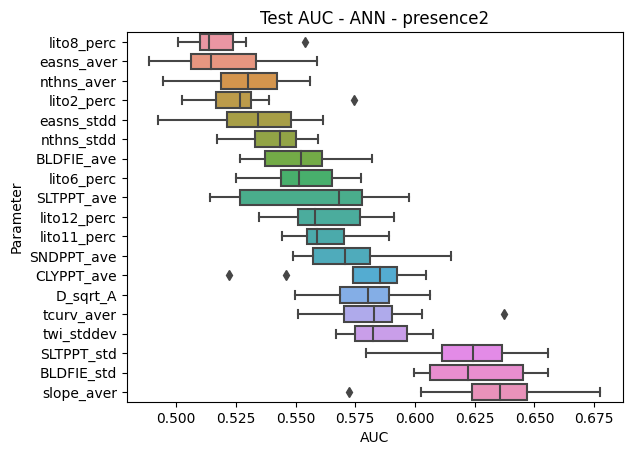

In [95]:
plt.title("Test AUC - ANN - presence2")
plt.xlabel("AUC")
plt.ylabel("Parameter")
sorted_performance_df_ann2 = performance_df_ann2.reindex(performance_df_ann2.mean().sort_values().index, axis=1)
sns.boxplot(sorted_performance_df_ann2, orient="h");

### Stepwise combination

In [96]:
ann2_max_to_min = list(reversed(sorted_performance_df_ann2.columns.to_list()))
performance_df_ann2_combined = pd.DataFrame()
columns_for_calc = []
old_test_auc = 0
for col in ann2_max_to_min:
  if col not in skip_list:
    columns_for_calc.append(col)
    auc_test_list = []
    for i, kf in enumerate(kf_list):
      tmp_train_df = pd.DataFrame()
      tmp_test_df = pd.DataFrame()
      for c in columns_for_calc:
        tmp_train_df[c] = kf["X_train"][c]
        tmp_test_df[c] = kf["X_test"][c]
      ann_tmp_comb1 = MLPClassifier(random_state=42, max_iter=500).fit(tmp_train_df, kf["y_train2"])
      auc_train = roc_auc_score(kf["y_train2"], ann_tmp_comb1.predict_proba(tmp_train_df)[:, 1])
      auc_test = roc_auc_score(kf["y_test2"], ann_tmp_comb1.predict_proba(tmp_test_df)[:, 1])
      #print(f"{i+1: <{2}}. Fold: X: {tmp_train_df.columns} -> {auc_train = : <{19}} - {auc_test = : <{19}}")
      auc_test_list.append(auc_test)
    mean_test_auc = np.median(auc_test)
    performance_df_ann2_combined[str(columns_for_calc)] = auc_test_list
    print(columns_for_calc)
    if mean_test_auc <= old_test_auc:
      print(f"Average Test AUC did not improve with {col}. Best: {old_test_auc}. New: {mean_test_auc}.")
      print(f"Removing {columns_for_calc.pop()} from list of columns.")
    else:
      print(f"Average Test AUC improved to {mean_test_auc}.")
      old_test_auc = mean_test_auc

['slope_aver']
Average Test AUC improved to 0.6415410973948952.
['slope_aver', 'BLDFIE_std']
Average Test AUC improved to 0.6859640644906208.
['slope_aver', 'BLDFIE_std', 'SLTPPT_std']
Average Test AUC improved to 0.7030180556165708.
['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'twi_stddev']
Average Test AUC improved to 0.7192461450599658.
['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'twi_stddev', 'tcurv_aver']
Average Test AUC improved to 0.7429161358344681.
['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'twi_stddev', 'tcurv_aver', 'D_sqrt_A']
Average Test AUC did not improve with D_sqrt_A. Best: 0.7429161358344681. New: 0.7396125291042481.
Removing D_sqrt_A from list of columns.
['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'twi_stddev', 'tcurv_aver', 'CLYPPT_ave']
Average Test AUC did not improve with CLYPPT_ave. Best: 0.7429161358344681. New: 0.7408513816280806.
Removing CLYPPT_ave from list of columns.
['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'twi_stddev', 'tcurv_aver', 'SNDPPT_ave']
Avera

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'twi_stddev', 'tcurv_aver', 'SNDPPT_ave', 'lito11_perc', 'lito12_perc', 'SLTPPT_ave', 'BLDFIE_ave', 'nthns_stdd', 'easns_aver', 'lito8_perc']
Average Test AUC improved to 0.7959759258445722.


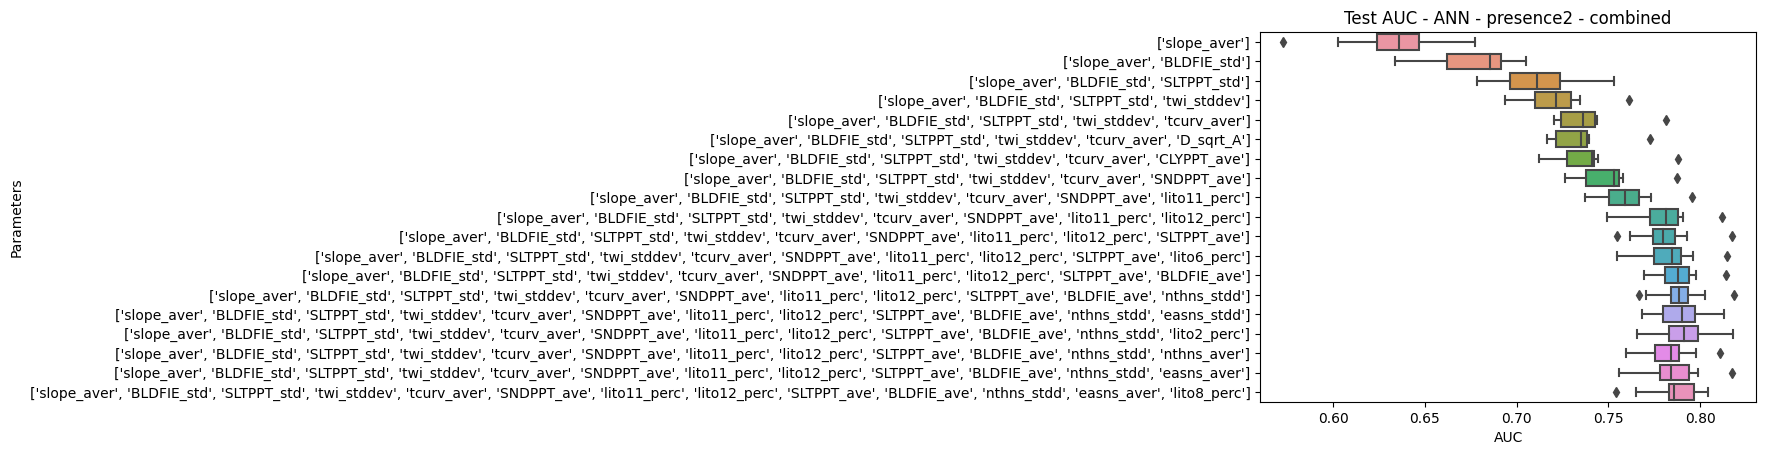

In [97]:
plt.title("Test AUC - ANN - presence2 - combined")
plt.xlabel("AUC")
plt.ylabel("Parameters")
sorted_performance_df_ann2_combined = performance_df_ann2_combined.reindex(performance_df_ann2_combined.median().index, axis=1)
sns.boxplot(sorted_performance_df_ann2_combined, orient="h");

## Visualize Results

In [98]:
gdf_ann_results = gdf.copy()

### ANN with label presence1

max_avg = 0.7760854648391308 Column: ['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave', 'twi_stddev', 'lito12_perc', 'tcurv_aver', 'SNDPPT_ave', 'SLTPPT_ave', 'lito2_perc', 'easns_stdd', 'BLDFIE_ave', 'lito8_perc', 'nthns_stdd']
max_single_fold = 0.7943188534278961 Column: ['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'lito11_perc', 'CLYPPT_ave', 'twi_stddev', 'lito12_perc', 'tcurv_aver', 'SNDPPT_ave', 'SLTPPT_ave', 'lito2_perc', 'easns_stdd', 'BLDFIE_ave', 'lito8_perc', 'nthns_stdd'] @ Fold 6


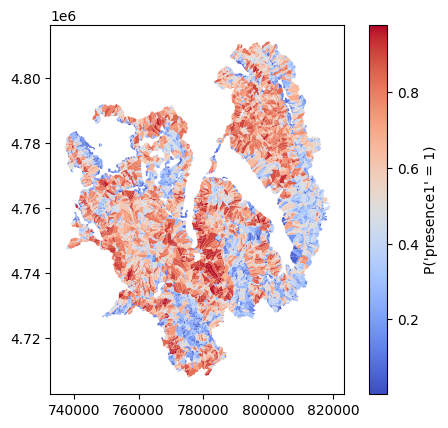

In [99]:
max_avg, max_avg_column, max_singlef, max_singlef_col, max_singlef_fold = get_stats_sorted_combined_calc_df(sorted_performance_df_ann1_combined)
columns = ast.literal_eval(max_singlef_col)
for i, kf in enumerate(kf_list):
  tmp_train_df = kf["X_train"].filter(columns)
  tmp_ann_presence1 = MLPClassifier(random_state=42, max_iter=500).fit(tmp_train_df, kf["y_train1"])
  tmp_ann_presence1_preds = tmp_ann_presence1.predict_proba(gdf_norm[columns])[:, 1]
  gdf_ann_results[f"presence1_preds_{i}_fold"] = tmp_ann_presence1_preds
presence1_pred_cols = [col for col in gdf_ann_results.columns if "presence1_preds_" in col]
gdf_ann_results["presence1_median_pred"] = gdf_ann_results[presence1_pred_cols].median(axis=1)
gdf_ann_results["presence1_mean_pred"] = gdf_ann_results[presence1_pred_cols].mean(axis=1)
gdf_ann_results["presence1_std_pred"] = gdf_ann_results[presence1_pred_cols].std(axis=1)
gdf_ann_results.plot(column="presence1_median_pred", legend=True,
                    cmap="coolwarm",
                    legend_kwds={'label': "P('presence1' = 1)"});

Text(0, 0.5, 'Total landslides (labels)')

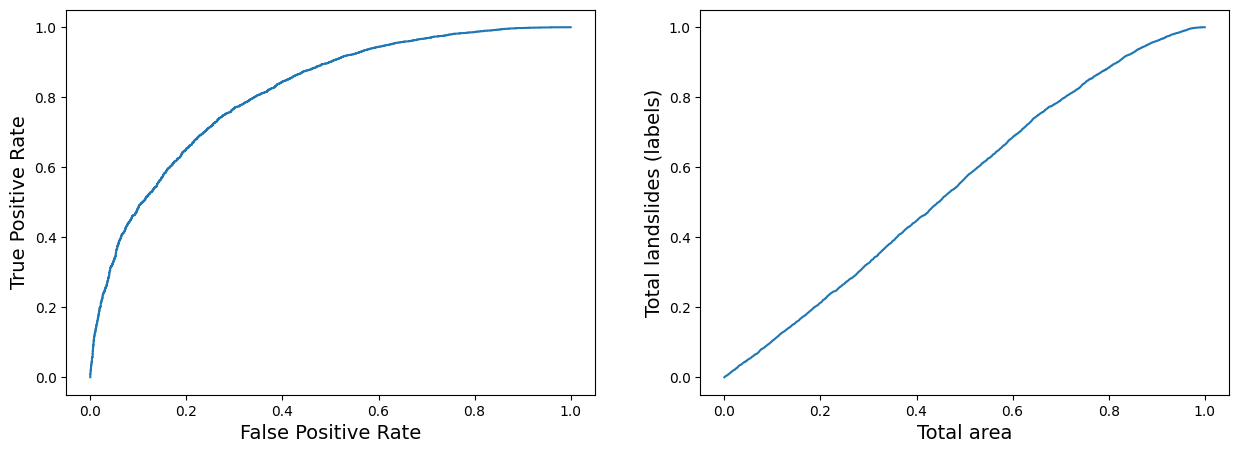

In [100]:
x, y, auc = get_success_rate(gdf_ann_results, "presence1_median_pred", "presence1")
fp, tp, thresh= get_roc_curve(gdf_ann_results,"presence1_median_pred", "presence1" )
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.set_xlabel("False Positive Rate", fontsize=14)
ax.set_ylabel("True Positive Rate", fontsize=14)
ax.plot(fp, tp, label=f"{col} AUC: {round(roc_auc_score(gdf['presence1'], gdf[col]), 2)}")


ax2 = fig.add_subplot(122)
ax2.plot(x, y, label=f"{col} AUC: {round(auc, 2)}")
ax2.set_xlabel("Total area", fontsize=14)
ax2.set_ylabel("Total landslides (labels)", fontsize=14)

### ANN with label presence2

max_avg = 0.7910116623827594 Column: ['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'twi_stddev', 'tcurv_aver', 'SNDPPT_ave', 'lito11_perc', 'lito12_perc', 'SLTPPT_ave', 'BLDFIE_ave', 'nthns_stdd', 'lito2_perc']
max_single_fold = 0.8182872978906335 Column: ['slope_aver', 'BLDFIE_std', 'SLTPPT_std', 'twi_stddev', 'tcurv_aver', 'SNDPPT_ave', 'lito11_perc', 'lito12_perc', 'SLTPPT_ave', 'BLDFIE_ave', 'nthns_stdd'] @ Fold 3


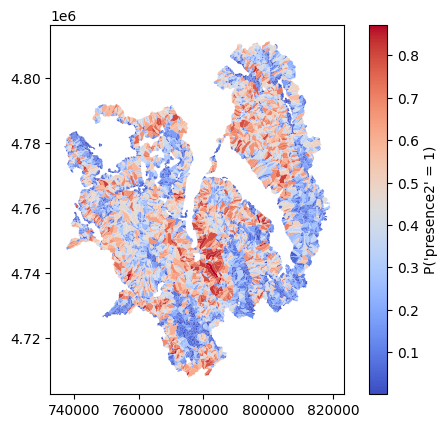

In [101]:
max_avg, max_avg_column, max_singlef, max_singlef_col, max_singlef_fold = get_stats_sorted_combined_calc_df(sorted_performance_df_ann2_combined)
columns = ast.literal_eval(max_singlef_col)
for i, kf in enumerate(kf_list):
  tmp_train_df = kf["X_train"].filter(columns)
  tmp_ann_presence2 = MLPClassifier(random_state=42, max_iter=500).fit(tmp_train_df, kf["y_train2"])
  tmp_ann_presence2_preds = tmp_ann_presence2.predict_proba(gdf_norm[columns])[:, 1]
  gdf_ann_results[f"presence2_preds_{i}_fold"] = tmp_ann_presence2_preds
presence2_pred_cols = [col for col in gdf_ann_results.columns if "presence2_preds_" in col]
gdf_ann_results["presence2_median_pred"] = gdf_ann_results[presence2_pred_cols].median(axis=1)
gdf_ann_results["presence2_mean_pred"] = gdf_ann_results[presence2_pred_cols].mean(axis=1)
gdf_ann_results["presence2_std_pred"] = gdf_ann_results[presence2_pred_cols].std(axis=1)
gdf_ann_results.plot(column="presence2_median_pred", legend=True,
                    cmap="coolwarm",
                    legend_kwds={'label': "P('presence2' = 1)"});

Text(0, 0.5, 'Total landslides (labels)')

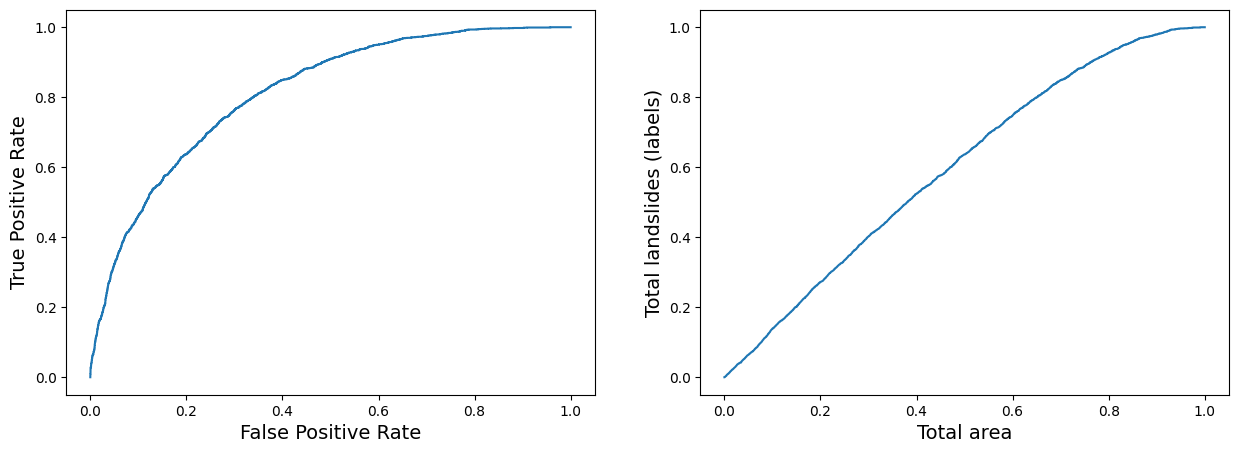

In [102]:
x, y, auc = get_success_rate(gdf_ann_results, "presence2_median_pred", "presence2")
fp, tp, thresh= get_roc_curve(gdf_ann_results,"presence2_median_pred", "presence2" )
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.set_xlabel("False Positive Rate", fontsize=14)
ax.set_ylabel("True Positive Rate", fontsize=14)
ax.plot(fp, tp, label=f"{col} AUC: {round(roc_auc_score(gdf['presence2'], gdf[col]), 2)}")


ax2 = fig.add_subplot(122)
ax2.plot(x, y, label=f"{col} AUC: {round(auc, 2)}")
ax2.set_xlabel("Total area", fontsize=14)
ax2.set_ylabel("Total landslides (labels)", fontsize=14)

In [103]:
gdf_ann_results.to_file("ann_output.gpkg")